In [1]:
import os
import operator
import random
import numpy as np
import pandas as pd
import csv
import re

from itertools import chain, islice
from functools import partial

import nltk
from nltk.tokenize import word_tokenize

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, precision_recall_fscore_support
from sklearn.utils.fixes import signature

import keras
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import InputLayer, Embedding, Flatten, Dense, Activation, Dropout, BatchNormalization, Input, Bidirectional, LSTM, GRU, TimeDistributed, concatenate
from keras.callbacks import EarlyStopping
from keras import backend as K

import tensorflow as tf

import matplotlib.pyplot as plt
from pprint import pprint

import gc
from numpy import array

Using TensorFlow backend.


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.set_random_seed(seed)
    
set_seed(1992)

<h2>Preprocessing</h2>

We operate on a subset of two datasets:
<ol>
    <li>
        <h4>LingSpam Dataset (Bare)</h4>
        <p>
            This is the dataset that we used in the 2nd assignment.
            It consists of a few large emails, appriximately 1000 messages with an average of 3500 words.
    </li>
    <li>
        <h4>Kaggles Spam/Ham Dataset</h4>
        <p>
            This dataset is bigger, consisting of approximately 5500 messages.
            Each messagehowever is quiet short and a lot of jargon is used in them.
        </p>
    </li>
</ol>

In [3]:
lingspam_data_path = "/media/spiros/Data/lingspam_public/bare/"
kaggle_data_path   = "Kaggle/kaggle_spam_data.csv"

In [4]:
def load_lingspam_data(path):

    ham, spam = [], []

    for dirpath, _, filenames in os.walk(path):
        for filename in filenames:
            with open(os.path.join(dirpath, filename), encoding="utf8") as file:
                message = file.read()
            if filename.startswith("spm"):
                spam.append(message)
            else:
                ham.append(message)

    return ham, spam

In [5]:
def load_kaggle_data(path):
    
    ham, spam = [], []
    
    pattern = re.compile("\"?(?P<Category>spam|ham),(?:\"\")?(?P<Text>.*?)(?:\"\"\")?;+")
    
    with open(path, 'r', encoding="utf8") as file:
        for line in file.readlines():
            match = pattern.match(line)
            if match:
                text = " ".join(word_tokenize(match["Text"]))
                if match["Category"].startswith("s"):
                    spam.append(text)
                else:
                    ham.append(text)
            
    return ham, spam

In [6]:
dataset = "lingspam" # Specify the dataset to be loaded: kaggle, lingspam, or both

ham, spam = \
    load_kaggle_data(kaggle_data_path) if dataset.startswith("k") else (
        load_lingspam_data(lingspam_data_path) if dataset.startswith("l") else
        tuple(map(operator.concat, load_kaggle_data(kaggle_data_path), load_lingspam_data(lingspam_data_path)))
    )
 
print("Ham: {}, Spam: {}".format(len(ham), len(spam)))

Ham: 2412, Spam: 481


In [7]:
def data_split(x, y, sizes=(0.1, 0.1)):
    
    data_size = len(x)
    splits = []
    
    for size in sizes:
        x, test_x, y, test_y = train_test_split(x, y, test_size=int(data_size*size), shuffle=True)
        splits.append((test_x, test_y))
    splits.append((x, y))
    
    return splits

In [8]:
x = ham + spam
y = [0] * len(ham) + [1] * len(spam)

(test_x, test_y), (valid_x, valid_y), (train_x, train_y) = data_split(x, y, sizes=(0.2, 0.08))

print("Split Sizes: {}".format(list(map(len, (train_x, valid_x, test_x)))))

Split Sizes: [2084, 231, 578]


<h3>Tokenizer Initialization</h3>
<p>We consider two tokenizers. <i>Tokenizer_TRAIN_GLB</i> is fitted in all tokens onservable in the training set. <i>Tokenizer_UNK</i> is fitted in a subset of the training sequences in order to simulate the unobservability of a number of tokens in the validation data.</p>

In [9]:
tokenizer_GLB = Tokenizer(num_words=None, lower=True, oov_token="*UNK*")
tokenizer_GLB.fit_on_texts(train_x)

print("Tokens discovered by Tokenizer_GLB: {}".format(len(tokenizer_GLB.word_index)))

Tokens discovered by Tokenizer_GLB: 51439


In [10]:
tokenizer_UNK = Tokenizer(num_words=None, lower=True, oov_token="*UNK*")
tokenizer_UNK.fit_on_texts(random.sample(train_x, len(train_x) - len(valid_x))) # We want the number of unknown words in the train set to be approximately the same as in the validation set.

print("Tokens discovered by Tokenizer_UNK: {}".format(len(tokenizer_UNK.word_index)))

Tokens discovered by Tokenizer_UNK: 48507


<h3>Tokenization</h3>
<p>We transform each set in sequences of tokens according the chosen tokenizer.</p>

In [11]:
tokenizer = tokenizer_UNK

In [12]:
train_sequences = pad_sequences(tokenizer.texts_to_sequences(train_x), maxlen=150, padding="post", truncating="post") # We are contrained by the hardware limitations.
input_length = len(train_sequences[0])

In [13]:
valid_sequences = pad_sequences(tokenizer.texts_to_sequences(valid_x), maxlen=input_length, padding="post", truncating="post")
test_sequences  = pad_sequences(tokenizer.texts_to_sequences(test_x), maxlen=input_length, padding="post", truncating="post")

<h2>Utilities</h2>

In [14]:
def clean_model(model):
    
    K.clear_session()
    del model
    gc.collect() 

In [15]:
def plot_history(history):
    
    plt.plot(
        history.history["acc"],
        label="Train"
    )
    plt.plot(
        history.history["val_acc"],
        label="Validation"
    )
    
    plt.title("Model Accuracy")
    plt.ylabel("Accuray")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="best")
    
    plt.show() 

In [16]:
def evaluate_model(model, sequences, y):
    y_pred = (model.predict(sequences).flatten() >= 0.5).astype(float)
    
    
    print(classification_report(y, y_pred))
    
    print("Accuracy: "+str(accuracy_score(y,  y_pred.round()))) 
    
    precision_curve, recall_curve, _ = precision_recall_curve(y,  y_pred.round())
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    plt.step(recall_curve, precision_curve, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall_curve, precision_curve, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')

In [17]:
glove_embeddings_path = "/media/spiros/Data/glove.6B/glove.6B.100d.txt"
embeddings_df = pd.read_csv(glove_embeddings_path, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE, na_values=None, keep_default_na=False)

In [18]:
token_iter = map(
    operator.itemgetter(0),
    sorted(
        filter(lambda item: item[1] <= tokenizer.num_words, tokenizer.word_index.items()) if tokenizer.num_words
            else tokenizer.word_index.items(),
        key=operator.itemgetter(1)
    )
)

embedding_weights = embeddings_df.reindex(chain((None,), token_iter), fill_value=0.0).values # The zero-indexed vector is used only for masking by the layer.

print("Non-Zero Embeddings: {}".format(np.count_nonzero(embedding_weights, axis=0)[0]))

Non-Zero Embeddings: 32806


<h2>Bidirectional LSTMs on Pretrained (Glove) Embeddings</h2>

In [19]:
inputs =  Input(shape=(150, ), dtype='int32')
embeddings = Embedding(
    input_dim=embedding_weights.shape[0],
    output_dim=embedding_weights.shape[1],
    input_length=input_length,
    embeddings_initializer="zeros",
    weights=[embedding_weights],
    trainable=False
)(inputs)
dropped_embeddings = Dropout(0.0)(embeddings)
lstms_1 = Bidirectional(LSTM(100, return_sequences=True))(dropped_embeddings)
lstms_2 = Bidirectional(LSTM(100))(lstms_1)
outputs = Dense(1, activation='sigmoid')(lstms_2)

# Wrap model
model = Model(inputs=inputs, outputs=outputs)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 100)          4850800   
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 200)          160800    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 5,252,601
Trainable params: 401,801
Non-trainable params: 4,850,800
____________________________________________________________

In [20]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [21]:
history = model.fit(
    train_sequences, train_y,
    validation_data=(valid_sequences, valid_y),
    batch_size=64,
    epochs=20,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True, verbose=1)],
    verbose=1
)

Train on 2084 samples, validate on 231 samples
Epoch 1/20
2084/2084 [==============================] - 17s 8ms/step - loss: 0.2761 - acc: 0.8872 - val_loss: 0.0754 - val_acc: 0.9827
Epoch 2/20
2084/2084 [==============================] - 15s 7ms/step - loss: 0.0683 - acc: 0.9789 - val_loss: 0.0540 - val_acc: 0.9784
Epoch 3/20
2084/2084 [==============================] - 15s 7ms/step - loss: 0.0370 - acc: 0.9885 - val_loss: 0.3830 - val_acc: 0.9091
Epoch 4/20
2084/2084 [==============================] - 15s 7ms/step - loss: 0.0621 - acc: 0.9760 - val_loss: 0.0328 - val_acc: 0.9827
Epoch 5/20
2084/2084 [==============================] - 15s 7ms/step - loss: 0.0209 - acc: 0.9942 - val_loss: 0.0176 - val_acc: 0.9913
Epoch 6/20
2084/2084 [==============================] - 15s 7ms/step - loss: 0.0241 - acc: 0.9933 - val_loss: 0.1079 - val_acc: 0.9437
Epoch 7/20
2084/2084 [==============================] - 15s 7ms/step - loss: 0.0268 - acc: 0.9899 - val_loss: 0.0165 - val_acc: 0.9957
Epoch 8/

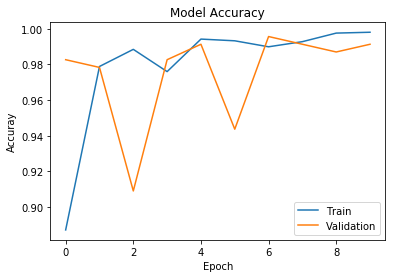

In [22]:
plot_history(history)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1740
           1       0.99      1.00      0.99       344

   micro avg       1.00      1.00      1.00      2084
   macro avg       1.00      1.00      1.00      2084
weighted avg       1.00      1.00      1.00      2084

Accuracy: 0.9980806142034548


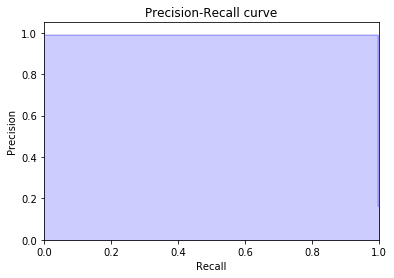

In [23]:
evaluate_model(model, train_sequences, train_y)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       192
           1       0.97      1.00      0.99        39

   micro avg       1.00      1.00      1.00       231
   macro avg       0.99      1.00      0.99       231
weighted avg       1.00      1.00      1.00       231

Accuracy: 0.9956709956709957


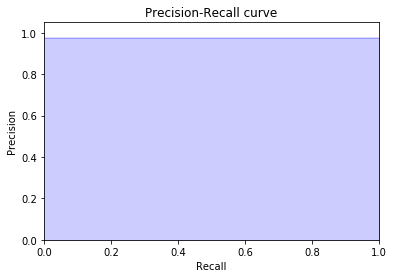

In [24]:
evaluate_model(model, valid_sequences, valid_y)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       480
           1       0.96      0.96      0.96        98

   micro avg       0.99      0.99      0.99       578
   macro avg       0.98      0.98      0.98       578
weighted avg       0.99      0.99      0.99       578

Accuracy: 0.986159169550173


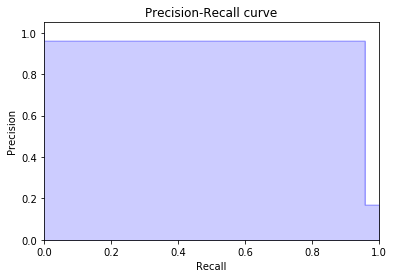

In [25]:
evaluate_model(model, test_sequences, test_y)

In [20]:
clean_model(model)

# Bidirectional LSTMs with self attention on Pretrained (Glove) Embeddings

## Self attention layer

In [21]:
from keras import initializers, regularizers, constraints
from keras.layers.core import Layer


def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)


class SimpleAttention(Layer):
    def __init__(self,
                 kernel_regularizer=None, bias_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):
        
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(kernel_regularizer)
        self.b_regularizer = regularizers.get(bias_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_attention = return_attention
        super(SimpleAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((1,),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, inputs, mask=None):
        # do not pass the mask to the next layers
        if self.return_attention:
            return [None, None]
        return None

    def call(self, x, mask=None):
        
        # eij = Wx + b
        eij = dot_product(x, self.W)

        if self.bias:
            eij += self.b

        # Apply mask
        if mask is not None:
            eij *= K.cast(mask, K.floatx())

        # a = softmax(eij)
        a = K.expand_dims(K.softmax(eij, axis=-1))
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]


class DeepAttention(Layer):
    def __init__(self,
                 kernel_regularizer=None, u_regularizer=None, bias_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(kernel_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(bias_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_attention = return_attention
        super(DeepAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(DeepAttention, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        # do not pass the mask to the next layers
        if self.return_attention:
            return [None, None]
        return None

    def call(self, x, mask=None):
        # uit = tanh(Wx + b)
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)

        # ait = softmax(Ueij)
        eij = dot_product(uit, self.u)

        # Apply mask
        if mask is not None:
            eij *= K.cast(mask, K.floatx())

        a = K.expand_dims(K.softmax(eij, axis=-1))
        
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

In [74]:
inputs =  Input(shape=(150, ), dtype='int32')
embeddings = Embedding(
    input_dim=embedding_weights.shape[0],
    output_dim=embedding_weights.shape[1],
    input_length=input_length,
    embeddings_initializer="zeros",
    weights=[embedding_weights],
    trainable=False
)(inputs)
dropped_embeddings = Dropout(0.0)(embeddings)
lstms_1 = Bidirectional(LSTM(100, return_sequences=True))(dropped_embeddings)
lstms_2 = Bidirectional(LSTM(100, return_sequences=True))(lstms_1)
attention =  DeepAttention()(lstms_2)
outputs = Dense(1, activation='sigmoid')(attention)

# Wrap model
model = Model(inputs=inputs, outputs=outputs)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 100)          4850800   
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 200)          160800    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 200)          240800    
_________________________________________________________________
deep_attention_1 (DeepAttent (None, 200)               40400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total para

In [75]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [76]:
history = model.fit(
    train_sequences, train_y,
    validation_data=(valid_sequences, valid_y),
    batch_size=64,
    epochs=20,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True, verbose=1)],
    verbose=1
)

Train on 2084 samples, validate on 231 samples
Epoch 1/20
2084/2084 [==============================] - 17s 8ms/step - loss: 0.2775 - acc: 0.8916 - val_loss: 0.1192 - val_acc: 0.9307
Epoch 2/20
2084/2084 [==============================] - 15s 7ms/step - loss: 0.1194 - acc: 0.9559 - val_loss: 0.0645 - val_acc: 0.9784
Epoch 3/20
2084/2084 [==============================] - 15s 7ms/step - loss: 0.0637 - acc: 0.9779 - val_loss: 0.0559 - val_acc: 0.9870
Epoch 4/20
2084/2084 [==============================] - 15s 7ms/step - loss: 0.0353 - acc: 0.9885 - val_loss: 0.0308 - val_acc: 0.9870
Epoch 5/20
2084/2084 [==============================] - 15s 7ms/step - loss: 0.0276 - acc: 0.9899 - val_loss: 0.0214 - val_acc: 0.9957
Epoch 6/20
2084/2084 [==============================] - 15s 7ms/step - loss: 0.0195 - acc: 0.9928 - val_loss: 0.0261 - val_acc: 0.9913
Epoch 7/20
2084/2084 [==============================] - 15s 7ms/step - loss: 0.0177 - acc: 0.9947 - val_loss: 0.0575 - val_acc: 0.9740
Epoch 8/

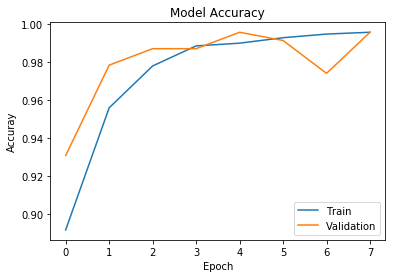

In [77]:
plot_history(history)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1740
           1       0.99      0.99      0.99       344

   micro avg       1.00      1.00      1.00      2084
   macro avg       0.99      0.99      0.99      2084
weighted avg       1.00      1.00      1.00      2084

Accuracy: 0.9961612284069098


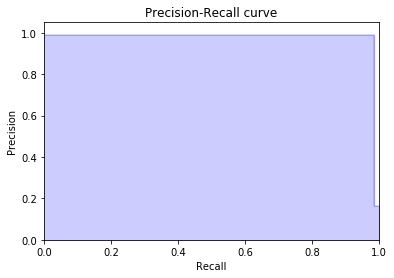

In [78]:
evaluate_model(model, train_sequences, train_y)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       192
           1       0.97      1.00      0.99        39

   micro avg       1.00      1.00      1.00       231
   macro avg       0.99      1.00      0.99       231
weighted avg       1.00      1.00      1.00       231

Accuracy: 0.9956709956709957


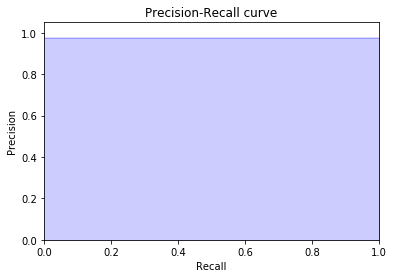

In [79]:
evaluate_model(model, valid_sequences, valid_y)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       480
           1       0.96      0.95      0.95        98

   micro avg       0.98      0.98      0.98       578
   macro avg       0.97      0.97      0.97       578
weighted avg       0.98      0.98      0.98       578

Accuracy: 0.9844290657439446


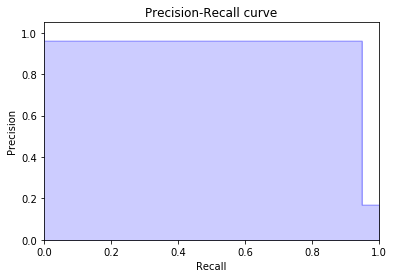

In [80]:
evaluate_model(model, test_sequences, test_y)

In [22]:
clean_model(model)

NameError: name 'model' is not defined

# Bidirectional LSTMs with self attention and ELMO on Pretrained (Glove) Embeddings

## ELMO

In [22]:
import tensorflow_hub as hub
from keras.layers import Layer

class ELMo(Layer):
    def __init__(self, elmo_representation='elmo', trainable=True, **kwargs):
        self.module_output = elmo_representation
        self.trainable = trainable

        self.elmo = None
        super(ELMo, self).__init__(**kwargs)

    def build(self, input_shape):
        # SetUp tensorflow Hub module
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2',
                               trainable=self.trainable, name="{}_module".format(self.name))
        # Assign module's trainable weights to model
        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        
        super(ELMo, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                           as_dict=True,
                           signature='default',
                           )[self.module_output]
        return result

    def compute_mask(self, inputs, mask=None):
        return None

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[0], 1024

W0506 22:49:04.318979 139735243384576 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [23]:
with tf.device('/cpu:0'):


    inputs =  Input(shape=(None, ), dtype='int32')
    elmo_inputs = Input(shape=(1,), dtype='string')
    embeddings = Embedding(
        input_dim=embedding_weights.shape[0],
        output_dim=embedding_weights.shape[1],
        #input_length=input_length,
        embeddings_initializer="zeros",
        weights=[embedding_weights],
        trainable=False
    )(inputs)

    # ELMo embeddings as weighted average across layers
    elmo_embeddings = ELMo()(elmo_inputs)
    # Concat Glove + ELMo embeddings
    concatenated_embeddings = concatenate([embeddings, elmo_embeddings], axis=-1)

    dropped_embeddings = Dropout(0.0)(concatenated_embeddings)
    lstms_1 = Bidirectional(LSTM(100, return_sequences=True))(dropped_embeddings)
    lstms_2 = Bidirectional(LSTM(100, return_sequences=True))(lstms_1)
    attention =  DeepAttention()(lstms_2)
    outputs = Dense(1, activation='sigmoid')(attention)

    # Wrap model
    model = Model(inputs=[inputs, elmo_inputs], outputs=outputs)
    model.summary(110)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0506 22:49:05.442323 139735243384576 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
input_1 (InputLayer)                (None, None)            0                                                 
______________________________________________________________________________________________________________
input_2 (InputLayer)                (None, 1)               0                                                 
______________________________________________________________________________________________________________
embedding_1 (Embedding)             (None, None, 100)       4850800      input_1[0][0]                        
______________________________________________________________________________________________________________
el_mo_1 (ELMo)                      (None, None, 1024)      4            input_2[0][0]                        
_

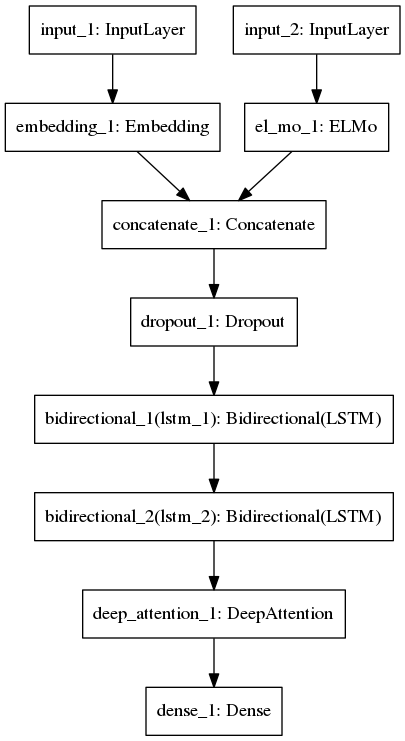

In [24]:
%matplotlib notebook

from keras.utils import plot_model
plot_model(model, to_file='model.png')

from IPython.display import Image 
Image('model.png')

In [25]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [26]:
history = model.fit(
    [train_sequences, array(tokenizer.sequences_to_texts(train_sequences))], train_y,
    validation_data=([valid_sequences, array(tokenizer.sequences_to_texts(valid_sequences))], valid_y),
    batch_size=256,
    epochs=20,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True, verbose=1)],
    verbose=1
)

Train on 2084 samples, validate on 231 samples
Epoch 1/20
2084/2084 [==============================] - 506s 243ms/step - loss: 0.3429 - acc: 0.7970 - val_loss: 0.0539 - val_acc: 0.9827
Epoch 2/20
2084/2084 [==============================] - 485s 233ms/step - loss: 0.0525 - acc: 0.9822 - val_loss: 0.0367 - val_acc: 0.9913
Epoch 3/20
2084/2084 [==============================] - 539s 259ms/step - loss: 0.0290 - acc: 0.9914 - val_loss: 0.0452 - val_acc: 0.9870
Epoch 4/20
2084/2084 [==============================] - 538s 258ms/step - loss: 0.0213 - acc: 0.9914 - val_loss: 0.0230 - val_acc: 0.9957
Epoch 5/20
2084/2084 [==============================] - 526s 252ms/step - loss: 0.0100 - acc: 0.9962 - val_loss: 0.0334 - val_acc: 0.9870
Epoch 6/20
2084/2084 [==============================] - 543s 261ms/step - loss: 0.0064 - acc: 0.9976 - val_loss: 0.0354 - val_acc: 0.9870
Epoch 7/20
2084/2084 [==============================] - 539s 259ms/step - loss: 0.0071 - acc: 0.9976 - val_loss: 0.0201 - val

<IPython.core.display.Javascript object>


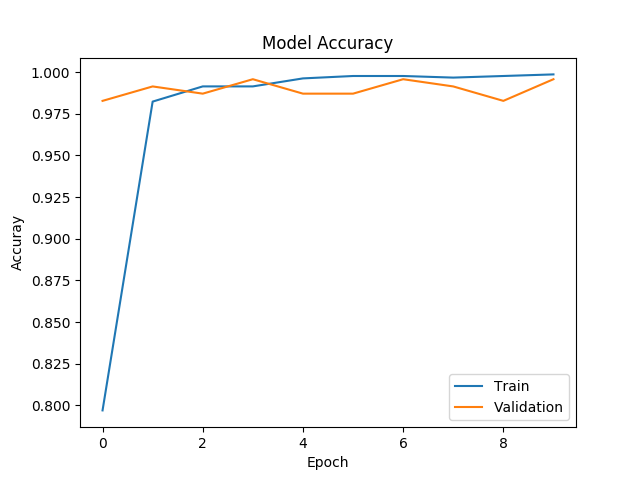

In [31]:
plot_history(history)

In [ ]:
evaluate_model(model, [valid_sequences, array(tokenizer.sequences_to_texts(valid_sequences))], valid_y)

In [30]:
evaluate_model(model, [test_sequences, array(tokenizer.sequences_to_texts(test_sequences))], test_y)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       480
           1       0.98      0.92      0.95        98

   micro avg       0.98      0.98      0.98       578
   macro avg       0.98      0.96      0.97       578
weighted avg       0.98      0.98      0.98       578

Accuracy: 0.9826989619377162


In [23]:
clean_model(model)

NameError: name 'model' is not defined